### Music gereration firth Keras and TensorFlow backend

Plan was simple:
1. Read midi file, convert it to matrix of features
2. Create simple model with Keras and LSTM to learn the pattern
3. Use subsample of initial midi file as a input for model to generate pure art
4. Save prediction from model to midi file
.
.
.
5. PROFIT

<i> For disclamer: I've been using my macbook with no GPU support</i>

In [9]:
import sys

!{sys.executable} -m pip install -q mido tqdm pandas tensorflow scikit-learn
# on my macOS I couldn't import keras properly, so I reinstall it with this command
# maybe you will need it too 🤷‍♂️
# !{sys.executable} -m  pip uninstall -y tensorflow keras tf-nightly keras-nightly

You should consider upgrading via the 'C:\Users\Irchade\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [10]:
import mido
import numpy as np
from mido import Message, MidiFile, MidiTrack
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence

##### Read midi file

In [11]:
mid = MidiFile(
    "Samples/Nintendo_-_Pokemon_Fire_Red_Route_1_Piano_Cover_Hard_Version.mid"
)
notes = []

##### Extract notes sequence
for the sake of simplicity I will use only 1 channel, it's like playining on piano with 1 hand 🙃

In [12]:
notes = []
for msg in mid:
    if not msg.is_meta and msg.channel == 0 and msg.type == "note_on":
        data = msg.bytes()
        notes.append(data[1])

#### Apply min-max scalling

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.array(notes).reshape(-1, 1))
notes = list(scaler.transform(np.array(notes).reshape(-1, 1)))

#### Prepare features for training and data subsample for prediction

In [14]:
# LSTM layers requires that data must have a certain shape
# create list of lists fist
notes = [list(note) for note in notes]

# subsample data for training and prediction
X = []
y = []
# number of notes in a batch
n_prev = 30
for i in range(len(notes) - n_prev):
    X.append(notes[i : i + n_prev])
    y.append(notes[i + n_prev])
# save a seed to do prediction later
X_test = X[-300:]
X = X[:-300]
y = y[:-300]

#### Made sequential model with several layers, use LSTM as it time dependent data

I also whant to save checkpoints

In [47]:
from keras.optimizers import RMSprop

model = Sequential()
model.add(LSTM(256, input_shape=(n_prev, 1), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(128, input_shape=(n_prev, 1), return_sequences=True))
model.add(Dropout(0.6))
model.add(LSTM(64, input_shape=(n_prev, 1), return_sequences=False))
model.add(Dropout(0.6))
model.add(Dense(1))
model.add(Activation("linear"))
optimizer = RMSprop(learning_rate=0.0001)
model.compile(loss="mse", optimizer=optimizer)
filepath = "./Checkpoints/checkpoint_model_{epoch:02d}.hdf5"
model_save_callback = ModelCheckpoint(
    filepath,
    monitor="val_acc",
    verbose=1,
    save_best_only=False,
    mode="auto",
    save_freq=5,
)

#### Train your model.
It might take a while, I was waiting for 1 hour with just 5 epoch

In [48]:
history=model.fit(np.array(X), np.array(y), 32, 7, verbose=1, callbacks=[model_save_callback])

Epoch 1/7
  4/400 [..............................] - ETA: 35s - loss: 0.1791
Epoch 1: saving model to ./Checkpoints\checkpoint_model_01.hdf5
  9/400 [..............................] - ETA: 36s - loss: 0.1394
Epoch 1: saving model to ./Checkpoints\checkpoint_model_01.hdf5
 14/400 [>.............................] - ETA: 36s - loss: 0.1233
Epoch 1: saving model to ./Checkpoints\checkpoint_model_01.hdf5
 19/400 [>.............................] - ETA: 35s - loss: 0.1112
Epoch 1: saving model to ./Checkpoints\checkpoint_model_01.hdf5
 24/400 [>.............................] - ETA: 36s - loss: 0.1044
Epoch 1: saving model to ./Checkpoints\checkpoint_model_01.hdf5
 29/400 [=>............................] - ETA: 35s - loss: 0.1009
Epoch 1: saving model to ./Checkpoints\checkpoint_model_01.hdf5
 34/400 [=>............................] - ETA: 35s - loss: 0.0983
Epoch 1: saving model to ./Checkpoints\checkpoint_model_01.hdf5
 39/400 [=>............................] - ETA: 34s - loss: 0.0960
Epoch 

#### Make a prediction

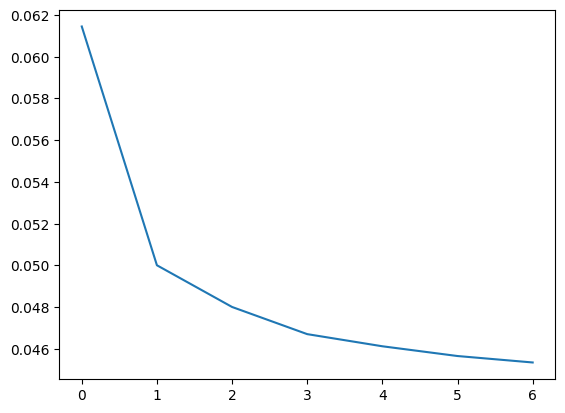

In [49]:
from matplotlib import pyplot as plt

plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [18]:
#plt.plot(history.epoch, history.history['accuracy'], label='Accuracy')
#plt.show()

In [50]:
prediction = model.predict(np.array(X_test))
prediction = np.squeeze(prediction)
prediction = np.squeeze(scaler.inverse_transform(prediction.reshape(-1, 1)))
prediction = [int(i) for i in prediction]

10/10 [==============================] - 1s 38ms/step


#### Save your result to new midi file

In [52]:
mid = MidiFile()
track = MidiTrack()
t = 0
for note in prediction:
    msg_on = Message.from_dict({'type': 'note_on', 'channel': 0, 'note': note, 'velocity': 67, 'time':0})
    # you need to add some pauses "note_off"
    msg_off = Message.from_dict({'type': 'note_off', 'channel': 0, 'note': note, 'velocity': 67, 'time':64})
    track.append(msg_on)
    track.append(msg_off)
    track.append(msg_off)
mid.tracks.append(track)
mid.save("LSTM_music.mid")

#### Just listen to it. The result is surreal!
